# Computer Vision: Basic Functionality

## Covered topics:

- Image and video capture from camera
- Video processing
- Save processed video
- Camera calibration
- ArUCo markers generation
- ArUCo markers detection
- Pose estimation
- Perspective projection

# Import libraries

In [3]:
import cv2
import os, glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


# Image capture from camera

In [ ]:
image_rgb = cv2.imread("img.jpeg")
gray = cv2.imread('img.jpg', 0)[:,10:1700]

red = image_rgb[:,:,0] # get blue channel
green = image_rgb[:,:,1] # get green channel
blue = image_rgb[:,:,2] # get red channel

cv2.imshow("Image", image_rgb)
cv2.waitKey(0) # wait for the user to press a key
cv2.destroyAllWindows()

# Video capture from camera

In [ ]:
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    print("Cannot open camera")
    exit()
while True:
    # capture frame-by-frame
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.imshow('frame', gray)
    if cv2.waitKey(1) == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

# Video file processing

In [ ]:
cap = cv2.VideoCapture('Video.mp4')
count = 0
frame_number = []

def func():
  print("func")

while cap.isOpened():
    ret,img = cap.read()
    if ret==True:
        img = img[10:-70,200:-230,:]
        height,width = img.shape[:2]
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        gray = cv2.medianBlur(gray,17)
        cv2.circle(gray,(20,50),20,255,thickness=-1)
        try:
          func()
        except:
          print("exception")

        frame_number.append(count)
        cv2.putText(img,'Frame= '+str(count),(50,50),cv2.FONT_HERSHEY_SIMPLEX,fontScale=1,color=(0,0,0),thickness=2)
        cv2.imshow('Pressure Gauge',img)
        count = count + 1

        if cv2.waitKey(10) & 0xFF == ord('q'):
            # save data and exit
            output_df = pd.DataFrame({'Frame': np.asarray(frame_number,dtype=int)})
            output_df.to_csv('test2.csv',index=False)
            break
        print(ret)
    else:
        print('Video finished')

print('Exiting...')
cap.release()
cv2.destroyAllWindows()

# Save processed video

In [ ]:
# read data
dst_images = sorted(glob.glob('dst_data/frames/*.jpg'))

i = 71
img_M = cv2.imread(dst_images[i])
img_M = cv2.cvtColor(img_M,cv2.COLOR_BGR2RGB)
h,w = img_M.shape[:2]

# build a frame
frame_width = 1024
frame_height = 768
frame = 50*np.ones((frame_height,frame_width,3),dtype=np.uint8)

frame[100:100+h,50:50+w,:] = img_M
cv2.putText(frame,'M:',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(250,250,250),2,cv2.LINE_AA)
print(frame.shape,frame.dtype)

fig = plt.figure(figsize=(10,8), dpi=80)
plt.imshow(frame)
plt.title('Output frame')
plt.show()

# write a video file
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
framerate = 1 # frames per second
out = cv2.VideoWriter('dst_data/output_video/vid.avi',fourcc,framerate,(frame_width,frame_height))

for i in tqdm(range(len(dst_images))):
    frame = 50*np.ones((frame_height,frame_width,3),dtype=np.uint8)
    img_M = cv2.imread(dst_images[i])
    frame[100:100+h,50:50+w,:] = img_M
    cv2.putText(frame,'M:',(50,100),cv2.FONT_HERSHEY_SIMPLEX,1,(250,250,250),2,cv2.LINE_AA)
    out.write(frame)
out.release()

# Camera calibration

In [ ]:
# https://docs.opencv.org/4.x/dc/dbb/tutorial_py_calibration.html
# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*7,3), np.float32)
objp[:,:2] = np.mgrid[0:7,0:6].T.reshape(-1,2)
# arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
images = glob.glob('*.jpg')
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # find the chess board corners
    ret, corners = cv2.findChessboardCorners(gray, (7,6), None)
    # if found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (7,6), corners2, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)
cv2.destroyAllWindows()

In [ ]:
# camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [ ]:
# undistortion
img = cv2.imread('left12.jpg')
h,  w = img.shape[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

# undistort
dst = cv2.undistort(img, mtx, dist, None, newcameramtx)
# crop the image
x, y, w, h = roi
dst = dst[y:y+h, x:x+w]
cv2.imwrite('calibresult.png', dst)

In [ ]:
# re-projection error (optimal is zero)
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
print("total error: {}".format(mean_error/len(objpoints)))

In [ ]:
# https://osf.io/9na7e
class RCamera():
    def __init__(self):
        # intrinsic camera parameters
        self.intrinsics = np.array([[1300.42739, 0,    418.781929],
                                    [0,    1303.92198, 387.691212],
                                    [0,    0,      1]], dtype = "float32")
        # distortion coefficients
        self.dist = np.array([[-4.12480510e-01,2.14136684e-01,
                               -1.04182515e-04,-3.40927851e-03,
                               -3.67091506e-01]],dtype="float32")
        # 2D image points
        self.TL_px = (46,241)
        self.BL_px = (345,530)
        self.TR_px = (390,53)
        self.BR_px = (716,250)

        # 3D model bed corner points
        self.TL_mm = (-45.0, 45.0, 0.0)
        self.BL_mm = (-45.0, -45.0, 0.0)
        self.TR_mm = (45.0, 45.0, 0.0)
        self.BR_mm = (45.0, -45.0, 0.0)

        self.corner_bed_points_2d = np.array([self.TL_px,self.TR_px,self.BR_px,self.BL_px],dtype="float32")
        self.corner_bed_points_3d = np.array([self.TL_mm,self.TR_mm,self.BR_mm,self.BL_mm],dtype="float32")

# ArUCo markers generation

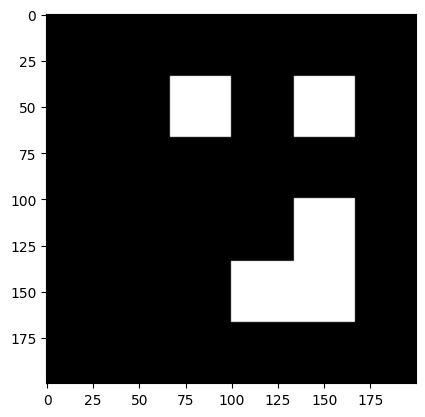

In [2]:
tag_size, id = 200, 49

img = np.zeros((tag_size, tag_size, 1), dtype="uint8")
arucoDict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_50)
cv2.aruco.generateImageMarker(arucoDict, id, tag_size, img, 1)
plt.imshow(img, cmap="gray")

# ArUCo markers detection (image)

- https://github.com/jatin-47/OctoPrint-ARPrintVisualizer/blob/main/octoprint_ARPrintVisualizer/OctoAR/detect_aruco_images.py
- https://github.com/GSNCodes/ArUCo-Markers-Pose-Estimation-Generation-Python
- https://aliyasineser.medium.com/aruco-marker-tracking-with-opencv-8cb844c26628
- https://mecaruco2.readthedocs.io/en/latest/notebooks_rst/Aruco/aruco_basics_video.html
- https://docs.opencv.org/4.x/d5/dae/tutorial_aruco_detection.html

In [ ]:
import numpy as np
import cv2
import sys

In [ ]:
ARUCO_DICT = {
	"DICT_4X4_50": cv2.aruco.DICT_4X4_50,
	"DICT_4X4_100": cv2.aruco.DICT_4X4_100,
	"DICT_4X4_250": cv2.aruco.DICT_4X4_250,
	"DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
	"DICT_5X5_50": cv2.aruco.DICT_5X5_50,
	"DICT_5X5_100": cv2.aruco.DICT_5X5_100,
	"DICT_5X5_250": cv2.aruco.DICT_5X5_250,
	"DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
	"DICT_6X6_50": cv2.aruco.DICT_6X6_50,
	"DICT_6X6_100": cv2.aruco.DICT_6X6_100,
	"DICT_6X6_250": cv2.aruco.DICT_6X6_250,
	"DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
	"DICT_7X7_50": cv2.aruco.DICT_7X7_50,
	"DICT_7X7_100": cv2.aruco.DICT_7X7_100,
	"DICT_7X7_250": cv2.aruco.DICT_7X7_250,
	"DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
	"DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
	"DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
	"DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
	"DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
	"DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
}

def aruco_display(corners, ids, rejected, image):
    if len(corners) > 0:
		# flatten the ArUco IDs list
        ids = ids.flatten()
        # loop over the detected ArUCo corners
        for (markerCorner, markerID) in zip(corners, ids):
            # extract the marker corners (which are always returned in
            # top-left, top-right, bottom-right, and bottom-left order)
            corners = markerCorner.reshape((4, 2))
            (topLeft, topRight, bottomRight, bottomLeft) = corners
			# convert each of the (x, y)-coordinate pairs to integers
            topRight = (int(topRight[0]), int(topRight[1]))
            bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
            bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
            topLeft = (int(topLeft[0]), int(topLeft[1]))

            cv2.line(image, topLeft, topRight, (255, 0, 0), 2)
            cv2.line(image, topRight, bottomRight, (0, 255, 0), 2)
            cv2.line(image, bottomRight, bottomLeft, (0, 255, 0), 2)
            cv2.line(image, bottomLeft, topLeft, (0, 255, 0), 2)
			# compute and draw the center (x, y)-coordinates of the ArUco
			# marker
            cX = int((topLeft[0] + bottomRight[0]) / 2.0)
            cY = int((topLeft[1] + bottomRight[1]) / 2.0)
            cv2.circle(image, (cX, cY), 4, (0, 0, 255), -1)
			# draw the ArUco marker ID on the image
            cv2.putText(image, str(markerID),(topLeft[0], topLeft[1] - 10), cv2.FONT_HERSHEY_SIMPLEX,
				0.5, (0, 255, 0), 2)
            print("[Inference] ArUco marker ID: {}".format(markerID))
			# show the output image
    return image


def get_centre(corner):
    """
    Returns the centre of a rectangle
    """
    (topLeft, topRight, bottomRight, bottomLeft)  = corner.reshape((4, 2))
    return int((topLeft[0] + bottomRight[0]) / 2.0), int((topLeft[1] + bottomRight[1]) / 2.0)



def get_rec_points(corners):
    """
    Return the four corners of the rectangle that is formed by the centre of the detected four aruco markers
    """
    if len(corners) == 4:
        points = []
        for corner in corners:
            points.append(get_centre(corner))
        #sort based on y value
        points.sort(key=lambda x: x[1])
        #sort based on x value
        points[0:2] = sorted(points[0:2], key=lambda x: x[0])
        points[2:4] = sorted(points[2:4], key=lambda x: x[0], reverse=True)

        points = np.array(points)
        points = np.int32(points)
        return points
    else:
        return None

In [ ]:
# python detect_aruco_images.py --image Images/1.png --type DICT_6X6_250

In [ ]:
image = cv2.imread("img.jpeg")
h, w, _ = image.shape
width = 1000
height = int(width*(h/w))
frame = cv2.resize(image, (width, height), interpolation=cv2.INTER_CUBIC)
img_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

# verify that the supplied ArUCo tag exists and is supported by OpenCV
if ARUCO_DICT.get("DICT_6X6_250", None) is None:
    print(f"ArUCo tag type '{'DICT_6X6_250'}' is not supported")
    sys.exit(0)

# load the ArUCo dictionary, grab the ArUCo parameters, and detect the markers
print("Detecting '{}' tags....".format("DICT_6X6_250"))
arucoDict = cv2.aruco.Dictionary_get(ARUCO_DICT["DICT_6X6_250"])
arucoParams = cv2.aruco.DetectorParameters_create()

corners, ids, rejected = cv2.aruco.detectMarkers(img_gray, arucoDict, parameters=arucoParams)
detected_markers = cv2.aruco.drawDetectedMarkers(frame, corners, ids)

#camera_matrix = np.load("calibration_matrix.npy")
#dist_coeffs = np.load("distortion_coefficients.npy")

points = get_rec_points(corners)
if points is not None:
    for point in points:
        cv2.circle(frame, tuple(point), 4, (0, 0, 255), -1)

    org_h, org_w = 16.5, 18.5 #in cm
    points_3D = np.array([[-org_w/2, org_h/2, 0], [org_w/2, org_h/2, 0], [org_w/2, -org_h/2, 0], [-org_w/2, -org_h/2, 0]], dtype="double")

    points_2D = points.astype('float32')
    points_3D = points_3D.astype('float32')

    success, rvecs, tvecs = cv2.solvePnP(points_3D, points_2D, camera_matrix, dist_coeffs)

    len = 5 #in cm
    axis = np.float32([[-len/2, -len/2, 0], [-len/2, len/2, 0], [len/2, len/2, 0], [len/2, -len/2, 0],
                        [-len/2, -len/2, len], [-len/2, len/2, len], [len/2, len/2, len],[len/2, -len/2, len]])

    imgpts_2d, jac = cv2.projectPoints(axis, rvecs, tvecs, camera_matrix, dist_coeffs)
    imgpts_2d = np.int32(imgpts_2d).reshape(-1, 2)

    frame = cv2.drawContours(frame, [imgpts_2d[:4]], -1, (255, 0, 0), 2)
    for i, j in zip(range(4), range(4, 8)):
        frame = cv2.line(frame, tuple(imgpts_2d[i]), tuple(imgpts_2d[j]), (255, 0, 0), 2)
    frame = cv2.drawContours(frame, [imgpts_2d[4:]], -1, (255, 0, 0), 2)


    # points = np.float32(points)
    # width = 800
    # height = int(width*(org_h/org_w))
    # target_points = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

    # M = cv2.getPerspectiveTransform(points, target_points)
    # warped = cv2.warpPerspective(frame, M, (width, height))

    # # cv2.imshow("Warped", warped)

cv2.imshow("Image", frame)

# # Uncomment to save
# cv2.imwrite("output_sample.png",detected_markers)

cv2.waitKey(0)

# ArUCo markers detection (video)

In [ ]:
# python detect_aruco_video.py --type DICT_6X6_250 --camera False --video test_video.mp4

video = cv2.VideoCapture(0)
if ARUCO_DICT.get("DICT_6X6_250", None) is None:
	print(f"ArUCo tag type '{'DICT_6X6_250'}' is not supported")
	sys.exit(0)

arucoDict = cv2.aruco.Dictionary_get(ARUCO_DICT["DICT_6X6_250"])
arucoParams = cv2.aruco.DetectorParameters_create()

camera_matrix = np.load("calibration_matrix.npy")
dist_coeffs = np.load("distortion_coefficients.npy")

while True:
	ret, img = video.read()
	# img = cv2.flip(img, 1)
	if ret is False:
		break

	h, w, _ = img.shape

	width=800
	height = int(width*(h/w))
	frame = cv2.resize(img, (width, height), interpolation=cv2.INTER_CUBIC)
	img_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)

	corners, ids, rejected = cv2.aruco.detectMarkers(img_gray, arucoDict, parameters=arucoParams)
	frame = cv2.aruco.drawDetectedMarkers(frame, corners, ids)

	points = get_rec_points(corners)
	if points is not None:
		for point in points:
			cv2.circle(frame, tuple(point), 4, (0, 0, 255), -1)

		org_h, org_w = 16.5, 18.5 #in cm
		points_3D = np.array([[-org_w/2, org_h/2, 0], [org_w/2, org_h/2, 0], [org_w/2, -org_h/2, 0], [-org_w/2, -org_h/2, 0]], dtype="double")

		points_2D = points.astype('float32')
		points_3D = points_3D.astype('float32')

		success, rvecs, tvecs = cv2.solvePnP(points_3D, points_2D, camera_matrix, dist_coeffs)

		len = 14 #in cm
		axis = np.float32([[-len/2, -len/2, 0], [-len/2, len/2, 0], [len/2, len/2, 0], [len/2, -len/2, 0],
							[-len/2, -len/2, len], [-len/2, len/2, len], [len/2, len/2, len],[len/2, -len/2, len]])

		imgpts_2d, jac = cv2.projectPoints(axis, rvecs, tvecs, camera_matrix, dist_coeffs)
		imgpts_2d = np.int32(imgpts_2d).reshape(-1, 2)

		frame = cv2.drawContours(frame, [imgpts_2d[:4]], -1, (255, 0, 0), 2)
		for i, j in zip(range(4), range(4, 8)):
			frame = cv2.line(frame, tuple(imgpts_2d[i]), tuple(imgpts_2d[j]), (0, 255, 10), 2)
		frame = cv2.drawContours(frame, [imgpts_2d[4:]], -1, (255, 0, 0), 2)

		points = np.float32(points)
		width = 800
		height = int(width*(org_h/org_w))
		target_points = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

		M = cv2.getPerspectiveTransform(points, target_points)
		warped = cv2.warpPerspective(frame, M, (width, height))

		cv2.imshow("Warped", warped)
	cv2.imshow("Image", frame)

	key = cv2.waitKey(1) & 0xFF
	if key == ord("q"):
		break

cv2.destroyAllWindows()
video.release()

# Pose estimation

In [ ]:
def pose_esitmation(frame, aruco_dict_type, matrix_coefficients, distortion_coefficients):

    '''
    frame - Frame from the video stream
    matrix_coefficients - Intrinsic matrix of the calibrated camera
    distortion_coefficients - Distortion coefficients associated with your camera

    return:-
    frame - The frame with the axis drawn on it
    '''

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    cv2.aruco_dict = cv2.aruco.Dictionary_get(aruco_dict_type)
    parameters = cv2.aruco.DetectorParameters_create()


    corners, ids, rejected_img_points = cv2.aruco.detectMarkers(gray, cv2.aruco_dict,parameters=parameters)

        # If markers are detected
    if len(corners) > 0:
        for i in range(0, len(ids)):
            # Estimate pose of each marker and return the values rvec and tvec---(different from those of camera coefficients)
            rvec, tvec, markerPoints = cv2.aruco.estimatePoseSingleMarkers(corners[i], 0.02, matrix_coefficients,
                                                                       distortion_coefficients)
            # Draw a square around the markers
            cv2.aruco.drawDetectedMarkers(frame, corners)

            # Draw Axis
            cv2.drawFrameAxes(frame, matrix_coefficients, distortion_coefficients, rvec, tvec, 0.01)

    return frame

    if __name__ == '__main__':

    ap = argparse.ArgumentParser()
    ap.add_argument("-k", "--K_Matrix", required=True, help="Path to calibration matrix (numpy file)")
    ap.add_argument("-d", "--D_Coeff", required=True, help="Path to distortion coefficients (numpy file)")
    ap.add_argument("-t", "--type", type=str, default="DICT_ARUCO_ORIGINAL", help="Type of ArUCo tag to detect")
    args = vars(ap.parse_args())


    if ARUCO_DICT.get(args["type"], None) is None:
        print(f"ArUCo tag type '{args['type']}' is not supported")
        sys.exit(0)

    aruco_dict_type = ARUCO_DICT[args["type"]]
    calibration_matrix_path = args["K_Matrix"]
    distortion_coefficients_path = args["D_Coeff"]

    k = np.load(calibration_matrix_path)
    d = np.load(distortion_coefficients_path)
    print(k)
    print(d)
    """
    video = cv2.VideoCapture(1)
    time.sleep(2.0)

    while True:
        ret, frame = video.read()

        if not ret:
            break

        output = pose_esitmation(frame, aruco_dict_type, k, d)

        cv2.imshow('Estimated Pose', output)

        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break

    video.release()
    cv2.destroyAllWindows()
    """

# Perspective projection

In [ ]:
class Image():

    def __init__(self):
        # dimensions of the unwrapped virtual top view (in pixels)
        self.top_width = 601
        self.top_height = 601


    def read(self,path):
        src_rgb = cv2.imread(path,cv2.IMREAD_COLOR)
        src_rgb = cv2.cvtColor(src_rgb, cv2.COLOR_BGR2RGB)
        return src_rgb


    def undistort_image(self,src_rgb,Camera):
        h, w = src_rgb.shape[:2]
        newcameramtx,roi=cv2.getOptimalNewCameraMatrix(Camera.intrinsics,\
                                                       Camera.dist,(w,h),1,(w,h))
        undistorted = cv2.undistort(src_rgb,Camera.intrinsics,\
                                    Camera.dist,None,newcameramtx)
        x,y,w,h = roi
        return undistorted[y:y+h,x:x+w]


    def project_plane(self,slice_height,Camera):
        # assuming no lens distortion (image is already undistorted)
        dist_coeffs = np.zeros((4,1))
        #dist_coeffs = Camera.dist
        (_,rotation_vector,translation_vector)=cv2.solvePnP(Camera.corner_bed_points_3d,\
                                                          Camera.corner_bed_points_2d,\
                                                          Camera.intrinsics,\
                                                          dist_coeffs,\
                                                          flags=cv2.cv2.SOLVEPNP_ITERATIVE)

        G_plane = np.zeros((4,4),dtype="float32")
        G_plane.T[:2] = Camera.corner_bed_points_3d.T[:2] # XY
        G_plane.T[2] = (slice_height)*np.ones((4),dtype="float32") # Z
        G_plane.T[3] = np.array([0,0,0,1],dtype="float32") # Homogenity

        # project G_plane on image
        pG_plane = cv2.projectPoints(np.asarray(G_plane[:,0:3],dtype=float),\
                                     rotation_vector,\
                                     translation_vector,\
                                     Camera.intrinsics,dist_coeffs)[0].reshape(-1, 2)
        return pG_plane


    def unwrap_image(self,undistorted_rgb,corner_points_2d):
        rst = np.array(corner_points_2d,dtype="float32")
        dst = np.array([[0,0],
                        [self.top_width-1,0],
                        [self.top_width-1,self.top_height-1],
                        [0,self.top_height-1]],dtype = "float32")
        M = cv2.getPerspectiveTransform(rst,dst)
        top_rgb = cv2.warpPerspective(undistorted_rgb,M,\
                                (self.top_width,self.top_height))
        return top_rgb


    def rotate_layer_slice(self,ot_x,ot_y,ot_z,otheta_x,otheta_y,otheta_z):
        # rotation around x, y, and z
        oRx=np.array([[1,0,0],[0,np.cos(otheta_x*np.pi/180),-np.sin(otheta_x*np.pi/180)],\
                        [0,np.sin(otheta_x*np.pi/180),np.cos(otheta_x*np.pi/180)]])
        oRy=np.array([[np.cos(otheta_y*np.pi/180),0,np.sin(otheta_y*np.pi/180)],[0,1,0],\
                        [-np.sin(otheta_y*np.pi/180),0,np.cos(otheta_y*np.pi/180)]])
        oRz=np.array([[np.cos(otheta_z*np.pi/180),-np.sin(otheta_z*np.pi/180),0],\
                        [np.sin(otheta_z*np.pi/180),np.cos(otheta_z*np.pi/180),0],[0,0,1]])

        oR = np.dot(np.dot(oRx,oRy),oRz)
        ot = np.array([ot_x,ot_y,ot_z])

        H = np.zeros((4,4), dtype="float32")
        H[0:3,0:3] = oR
        H[0:3,3] = ot.T
        H[3,3] = 1
        return H

    def project_layer_slice(self,H,stl_slice,Camera):
        # assuming no lens distortion (image is already undistorted)
        # distortion should be equal to zero
        dist_coeffs = np.zeros((4,1))
        (_,rotation_vector,translation_vector)=cv2.solvePnP(Camera.corner_bed_points_3d,\
                                                          Camera.corner_bed_points_2d,\
                                                          Camera.intrinsics,\
                                                          dist_coeffs,\
                                                          flags=cv2.cv2.SOLVEPNP_ITERATIVE)
        verts = stl_slice.vertices

        G_plane = np.zeros((len(verts),4),dtype="float32")
        G_plane.T[:3] = np.asarray(verts).T # XYZ
        G_plane.T[3] = np.ones((1,len(verts)),dtype="float32")

        # tG_plane -> transformed (rototranslated) G_plane
        # ptG_plane -> projected tG_plane
        tG_plane = np.zeros((len(verts),4),dtype=np.float32)

        # rototranslate G_plane
        for i in range(len(verts)):
            tG_plane[i] = np.dot(H,G_plane[i])

        # project g-code or stl layer plane on the image
        ptG_plane = cv2.projectPoints(np.asarray(tG_plane[:,0:3],dtype=float),\
                                      rotation_vector,\
                                      translation_vector,\
                                      Camera.intrinsics,dist_coeffs)[0].reshape(-1, 2)
        return ptG_plane


    def project_stl_mask(self,H,stl_slice,slice_height,undistorted_rgb,Camera):
        # assuming no lens distortion (image is already undistorted)
        # distortion should be equal to zero
        dist_coeffs = np.zeros((4,1))
        (_,rotation_vector,translation_vector)=cv2.solvePnP(Camera.corner_bed_points_3d,\
                                                          Camera.corner_bed_points_2d,\
                                                          Camera.intrinsics,\
                                                          dist_coeffs,\
                                                          flags=cv2.cv2.SOLVEPNP_ITERATIVE)
        slice_2D,to_3D = stl_slice.to_planar()
        outer_polys = [x.exterior for x in slice_2D.polygons_full]

        mask = np.zeros(undistorted_rgb.shape,dtype=np.int32)

        for p in (slice_2D.polygons_closed):
            if p.exterior in outer_polys:
                poly = np.asarray(p.exterior.xy,dtype=np.float32).T
                G_plane = np.zeros((len(poly),4),dtype=np.float32)
                G_plane.T[:2] = poly.T # XY
                G_plane.T[2] = slice_height*np.ones((1,len(poly)),dtype=np.float32) # Z
                G_plane.T[3] = np.ones((1,len(poly)),dtype=np.float32)

                tG_plane = np.zeros((len(poly),4),dtype=np.float32)
                for i in range(len(poly)):
                    tG_plane[i] = np.dot(H,G_plane[i])
                ptG_plane = cv2.projectPoints(np.asarray(tG_plane[:,0:3],dtype=float),\
                                      rotation_vector,\
                                      translation_vector,\
                                      Camera.intrinsics,dist_coeffs)[0].reshape(-1, 2)
                cv2.fillPoly(mask,[np.asarray(ptG_plane,dtype=np.int32)],color =(255,255,255))
            else:
                poly = np.asarray(p.exterior.xy,dtype=np.float32).T
                G_plane = np.zeros((len(poly),4),dtype=np.float32)
                G_plane.T[:2] = poly.T # XY
                G_plane.T[2] = slice_height*np.ones((1,len(poly)),dtype=np.float32) # Z
                G_plane.T[3] = np.ones((1,len(poly)),dtype=np.float32)

                tG_plane = np.zeros((len(poly),4),dtype=np.float32)
                for i in range(len(poly)):
                    tG_plane[i] = np.dot(H,G_plane[i])
                ptG_plane = cv2.projectPoints(np.asarray(tG_plane[:,0:3],dtype=float),\
                                      rotation_vector,\
                                      translation_vector,\
                                      Camera.intrinsics,dist_coeffs)[0].reshape(-1, 2)
                cv2.fillPoly(mask,[np.asarray(ptG_plane,dtype=np.int32)],color =(0,0,0))
        mask = np.asarray((mask/255),dtype=np.uint8)
        return mask

    def center_bbox(self,top_rgb,top_mask_rgb,size=400):
        gray_top = cv2.cvtColor(top_rgb, cv2.COLOR_RGB2GRAY)
        gray_mask = top_mask_rgb[:,:,0]

        rows = np.any(gray_mask, axis=1)
        cols = np.any(gray_mask, axis=0)
        rmin, rmax = np.where(rows)[0][[0, -1]]
        cmin, cmax = np.where(cols)[0][[0, -1]]

        center_x = int(cmin+(cmax-cmin)/2)
        center_y = int(rmin+(rmax-rmin)/2)

        centered_top = gray_top[int(center_y-size/2):int(center_y+size/2),
                               int(center_x-size/2):int(center_x+size/2)]
        centered_mask = gray_mask[int(center_y-size/2):int(center_y+size/2),
                                  int(center_x-size/2):int(center_x+size/2)]

        return centered_top,centered_mask